<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Import the packege

In [349]:
import shap
import time
import logging
import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import wilcoxon, bootstrap
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from scipy.stats import wilcoxon, bootstrap, uniform, randint


warnings.filterwarnings('ignore')

## logging fit

In [350]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## seed

In [351]:
SEED = 42  
np.random.seed(SEED)

# read data set

In [352]:
df_xlsx = pd.read_excel('../data/DummyData.xlsx')

df_xlsx.to_csv('../data/DummyData.csv', index=False)
logger.info("change the xlsx form csv file done! ")
df = pd.read_csv('../data/DummyData.csv')
df.shape
logger.info('read the csv file')
df_original = df.copy()
logger.info("copy data set done!")

2025-06-07 09:33:44,639 - INFO - change the xlsx form csv file done! 
2025-06-07 09:33:44,665 - INFO - read the csv file
2025-06-07 09:33:44,669 - INFO - copy data set done!


In [353]:
df.head()

,sex,age,educational_status,partner_status,employment_status,weight,height,BMI,treatment,EMI,...,nitrate,diuretic,psychotropic,angiotensin2_receptor_blocker,week,steps,mvpa_mins,perception,steps_goal,mvpa_mins_goal
0,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,72765,2105,16,95047.0,2509.0
1,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,53817,1557,2,74490.0,2063.0
2,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,58911,1704,4,70379.0,2163.0
3,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,85157,2463,8,125754.0,3164.0
4,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,51341,1485,12,68819.0,1886.0


In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sex                            566 non-null    int64  
 1   age                            564 non-null    float64
 2   educational_status             561 non-null    float64
 3   partner_status                 561 non-null    float64
 4   employment_status              561 non-null    float64
 5   weight                         561 non-null    float64
 6   height                         561 non-null    float64
 7   BMI                            561 non-null    float64
 8   treatment                      561 non-null    float64
 9   EMI                            559 non-null    float64
 10  EAP                            559 non-null    float64
 11  EPTCA                          559 non-null    float64
 12  ECABG                          559 non-null    flo

In [355]:
df.describe()

,sex,age,educational_status,partner_status,employment_status,weight,height,BMI,treatment,EMI,...,nitrate,diuretic,psychotropic,angiotensin2_receptor_blocker,week,steps,mvpa_mins,perception,steps_goal,mvpa_mins_goal
count,566.000000,564.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,559.000000,...,561.000000,561.000000,561.000000,561.000000,561.000000,566.000000,566.000000,566.000000,531.000000,530.000000
mean,1.526502,48.753546,1.909091,0.520499,1.522282,77.306595,170.602496,26.537683,0.898396,0.157424,...,0.119430,0.160428,0.119430,0.155080,3.522282,42170.001767,1023.332155,5.328622,55226.549906,1260.035849
std,0.499739,14.723789,0.806628,0.500025,0.499949,15.792022,10.074398,4.984085,0.835815,0.364526,...,0.324583,0.367330,0.324583,0.362304,1.925381,22804.693283,624.349263,4.213101,30099.992532,773.527674
min,1.000000,25.000000,1.000000,0.000000,1.000000,46.000000,150.000000,17.170000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,2145.000000,5.000000,0.000000,3089.000000,6.000000
25%,1.000000,36.000000,1.000000,0.000000,1.000000,64.000000,164.000000,22.940000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,23264.000000,604.250000,2.000000,30682.500000,716.250000
50%,2.000000,47.000000,2.000000,1.000000,2.000000,78.000000,170.000000,26.300000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,42602.000000,961.000000,5.000000,54642.000000,1153.500000
75%,2.000000,62.000000,3.000000,1.000000,2.000000,90.000000,178.000000,29.970000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,58830.250000,1400.750000,8.000000,77647.500000,1743.750000
max,2.000000,75.000000,3.000000,1.000000,2.000000,106.000000,190.000000,38.540000,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,8.000000,102990.000000,2745.000000,20.000000,143791.000000,3617.000000


In [356]:
df.columns

Index(['sex', 'age', 'educational_status', 'partner_status',
       'employment_status', 'weight', 'height', 'BMI', 'treatment', 'EMI',
       'EAP', 'EPTCA', 'ECABG', 'ECVA_TIA', 'riskfactor_familyhistory',
       'riskfactor_DM', 'riskfactor_hypertension', 'riskfactor_dyslipidemia',
       'riskfactor_smoking', 'acetylsalicylic_acid',
       'cholesterol_lowering_med', 'ACE_inhibitor', 'calcium_blocker',
       'beta_blocker', 'thienopyridine', 'oral_anticoagulant', 'nitrate',
       'diuretic', 'psychotropic', 'angiotensin2_receptor_blocker', 'week',
       'steps', 'mvpa_mins', 'perception', 'steps_goal', 'mvpa_mins_goal'],
      dtype='object')

In [357]:
df = df.dropna(subset=['steps_goal', 'mvpa_mins_goal'])
logger.info("Deleted rows with missing targets")
print(f"THis is the shape of data {df.shape}")

2025-06-07 09:33:48,851 - INFO - Deleted rows with missing targets


THis is the shape of data (525, 36)


In [358]:
# Drop the 'week' column
df = df.drop('week', axis=1)
logger.info("Dropped the week column")

2025-06-07 09:33:49,763 - INFO - Dropped the week column


# Split features and targets

In [359]:

X = df.drop(['steps_goal', 'mvpa_mins_goal'], axis=1)
y = df[['steps_goal', 'mvpa_mins_goal']]

# Split data into train, validation, and holdout

In [360]:
X_temp, X_holdout, y_temp, y_holdout = train_test_split(X, y, test_size=0.15, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=SEED)
logger.info("Data split into train, validation, and holdout")
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_holdout:", X_holdout.shape)

2025-06-07 09:33:53,417 - INFO - Data split into train, validation, and holdout


X_train: (356, 33) X_val: (90, 33) X_holdout: (79, 33)


In [361]:
numeric_columns = ['age', 'weight', 'height', 'BMI', 'steps', 'mvpa_mins',]
categorical_columns = ['educational_status', 'partner_status', 'employment_status', 
                      'treatment', 'riskfactor_familyhistory', 'riskfactor_DM', 
                      'riskfactor_hypertension', 'riskfactor_dyslipidemia', 
                      'riskfactor_smoking', 'acetylsalicylic_acid', 
                      'cholesterol_lowering_med', 'ACE_inhibitor', 
                      'calcium_blocker', 'beta_blocker', 'thienopyridine', 
                      'nitrate', 'diuretic', 'psychotropic', 
                      'angiotensin2_receptor_blocker']
extra_columns = ['EMI', 'EAP', 'EPTCA', 'ECABG', 'ECVA_TIA']

# Multiple Imputation using IterativeImputer (MICE)
# We apply imputation after splitting to avoid data leakage

In [362]:
all_columns = numeric_columns + categorical_columns + extra_columns
imputer = IterativeImputer(max_iter=10, random_state=SEED)
X_train_imputed = imputer.fit_transform(X_train[all_columns])
X_val_imputed = imputer.transform(X_val[all_columns])
X_holdout_imputed = imputer.transform(X_holdout[all_columns])

In [363]:
X_train = pd.DataFrame(X_train_imputed, columns=all_columns, index=X_train.index)
X_val = pd.DataFrame(X_val_imputed, columns=all_columns, index=X_val.index)
X_holdout = pd.DataFrame(X_holdout_imputed, columns=all_columns, index=X_holdout.index)
logger.info("Missing values imputed using Multiple Imputation (MICE)")

2025-06-07 09:33:58,071 - INFO - Missing values imputed using Multiple Imputation (MICE)


In [364]:
for col in numeric_columns:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train[col] = X_train[col].clip(lower=lower_bound, upper=upper_bound)
    X_val[col] = X_val[col].clip(lower=lower_bound, upper=upper_bound)
    X_holdout[col] = X_holdout[col].clip(lower=lower_bound, upper=upper_bound)
logger.info("Outliers clipped using train statistics")

2025-06-07 09:33:59,700 - INFO - Outliers clipped using train statistics


In [365]:
X_train.to_csv('../data/X_train_cleaned.csv', index=False)

## Pipeline

In [366]:
X_train

,age,weight,height,BMI,steps,mvpa_mins,educational_status,partner_status,employment_status,treatment,...,thienopyridine,nitrate,diuretic,psychotropic,angiotensin2_receptor_blocker,EMI,EAP,EPTCA,ECABG,ECVA_TIA
230,28.0,77.0,165.0,28.28,94284.0,1482.0,3.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,1.000000
143,65.0,83.0,162.0,31.63,21780.0,619.0,2.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.00000,0.000000,1.000000,0.000000,0.000000
325,44.0,57.0,166.0,20.69,7431.0,1137.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
245,57.0,77.0,164.0,28.63,9456.0,452.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
379,53.0,83.0,186.0,23.99,55914.0,1086.0,2.0,0.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.00000,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,75.0,77.0,150.0,34.22,78047.0,1059.0,1.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.00000,0.000000,0.000000,0.000000,0.000000
35,75.0,77.0,150.0,34.22,61926.0,840.0,1.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.53092,-0.075276,0.149739,0.096161,0.330389
517,37.0,78.0,150.0,34.67,53834.0,1877.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.00000,0.000000,1.000000,1.000000,1.000000
491,32.0,71.0,171.0,24.28,18261.0,1131.0,2.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000


In [367]:
num_features = all_columns

In [368]:
numeric_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_regression, k=10))
])
preprocessor = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('num', numeric_transformer, num_features)
    ]))
])
pipeline = Pipeline([
    ('imputer', IterativeImputer(max_iter=10, random_state=SEED)),
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_regression, k=10)),
    ('regressor', None) 
])


In [369]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train['steps_goal'])
X_val_preprocessed = preprocessor.transform(X_val)
X_holdout_preprocessed = preprocessor.transform(X_holdout)

In [370]:
selected_features_mask = preprocessor.named_steps['column_transformer'].named_transformers_['num'].named_steps['selector'].get_support()
selected_features = [num_features[i] for i in range(len(num_features)) if selected_features_mask[i]]
print("Selected features:", selected_features)
logger.info("Feature selection completed")

2025-06-07 09:34:10,895 - INFO - Feature selection completed


Selected features: ['weight', 'steps', 'mvpa_mins', 'treatment', 'riskfactor_hypertension', 'riskfactor_smoking', 'acetylsalicylic_acid', 'beta_blocker', 'psychotropic', 'angiotensin2_receptor_blocker']


## corr 

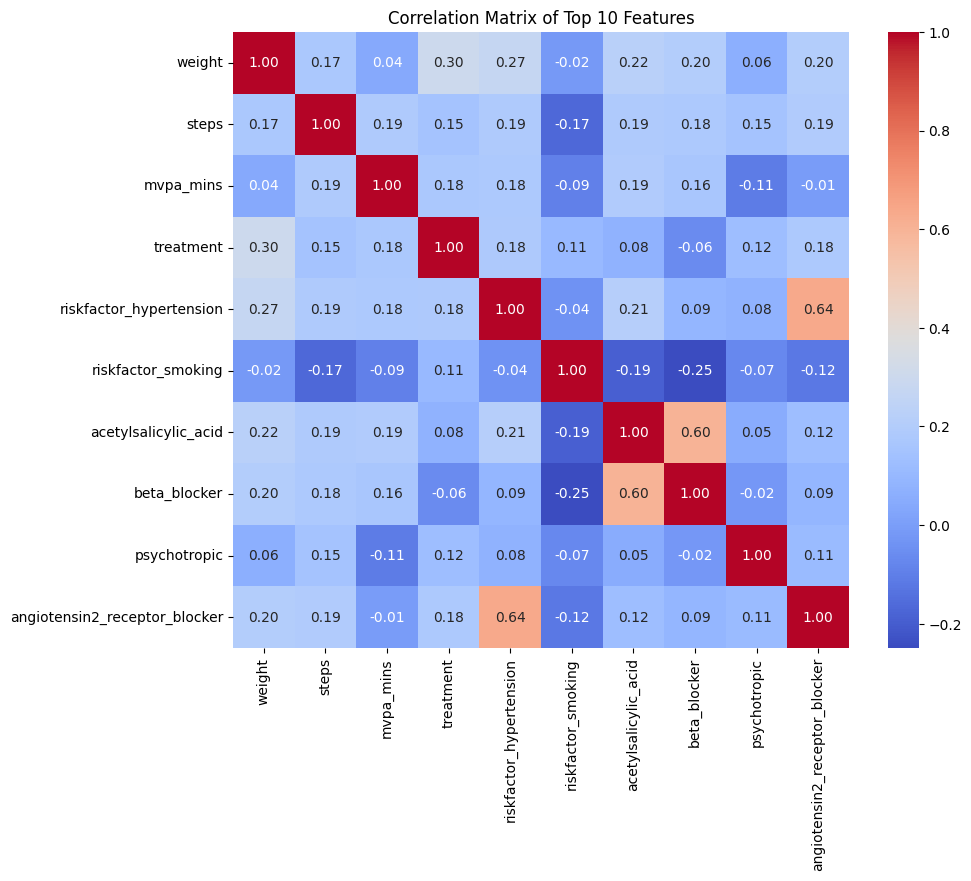

2025-06-07 09:34:15,911 - INFO - Correlation matrix saved as '../photo/correlation_matrix.png'


In [371]:
X_train_selected = X_train[selected_features]
correlation_matrix = X_train_selected.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Top 10 Features')
plt.savefig('../photo/correlation_matrix.png')
plt.show()
logger.info("Correlation matrix saved as '../photo/correlation_matrix.png'")

In [372]:
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)
logger.info(f"This is a number of the cross val: {cv}")

2025-06-07 09:34:16,691 - INFO - This is a number of the cross val: RepeatedKFold(n_repeats=2, n_splits=5, random_state=42)


# model

In [373]:
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'KNN': KNeighborsRegressor(),
    'MLP': MLPRegressor(max_iter=1000, random_state=SEED),
    'ExtraTrees': ExtraTreesRegressor(random_state=SEED),
    'RandomForest': RandomForestRegressor(random_state=SEED),
    'GradientBoosting': GradientBoostingRegressor(random_state=SEED),
    'XGBoost': XGBRegressor(random_state=SEED),
}


In [374]:
targets = y
results_cv = {}

for name, model in models.items():
    results_cv[name] = {}
    for target in targets:
        logger.info(f"Training {name} for target: {target}")
        pipeline.set_params(regressor=model)
        scores = cross_validate(
            pipeline, X_temp, y_temp[target],
            scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
            cv=cv,
            return_train_score=False,
            n_jobs=-1
        )
        results_cv[name][f'{target}_R2'] = np.mean(scores['test_r2'])
        results_cv[name][f'{target}_MAE'] = -np.mean(scores['test_neg_mean_absolute_error'])
        results_cv[name][f'{target}_RMSE'] = np.sqrt(-np.mean(scores['test_neg_mean_squared_error']))


df_cv_results = pd.DataFrame(results_cv).T
df_cv_results = df_cv_results.sort_values(by=['steps_goal_R2'], ascending=False)
print(df_cv_results)

2025-06-07 09:36:16,074 - INFO - Training Linear for target: steps_goal


2025-06-07 09:36:18,577 - INFO - Training Linear for target: mvpa_mins_goal
2025-06-07 09:36:21,771 - INFO - Training Ridge for target: steps_goal
2025-06-07 09:36:24,794 - INFO - Training Ridge for target: mvpa_mins_goal
2025-06-07 09:36:28,334 - INFO - Training Lasso for target: steps_goal
2025-06-07 09:36:31,520 - INFO - Training Lasso for target: mvpa_mins_goal
2025-06-07 09:36:34,485 - INFO - Training ElasticNet for target: steps_goal
2025-06-07 09:36:37,989 - INFO - Training ElasticNet for target: mvpa_mins_goal
2025-06-07 09:36:40,405 - INFO - Training KNN for target: steps_goal
2025-06-07 09:36:42,768 - INFO - Training KNN for target: mvpa_mins_goal
2025-06-07 09:36:44,783 - INFO - Training MLP for target: steps_goal
2025-06-07 09:37:17,659 - INFO - Training MLP for target: mvpa_mins_goal
2025-06-07 09:37:55,106 - INFO - Training ExtraTrees for target: steps_goal
2025-06-07 09:38:05,013 - INFO - Training ExtraTrees for target: mvpa_mins_goal
2025-06-07 09:38:12,799 - INFO - Tra

                  steps_goal_R2  steps_goal_MAE  steps_goal_RMSE  \
Ridge                  0.963502     4285.600160      5610.037302   
Lasso                  0.963499     4284.120420      5608.241352   
Linear                 0.963491     4284.738522      5608.906549   
RandomForest           0.955077     4641.183814      6233.194127   
GradientBoosting       0.954092     4648.502169      6313.434609   
ExtraTrees             0.950893     4847.264490      6543.480871   
XGBoost                0.944175     5087.667865      6962.069816   
ElasticNet             0.848742     9524.288220     11594.913580   
KNN                    0.775842    10515.228225     14021.102476   
MLP                   -3.403269    54450.397094     61654.327056   

                  mvpa_mins_goal_R2  mvpa_mins_goal_MAE  mvpa_mins_goal_RMSE  
Ridge                      0.982539           76.311734           104.033157  
Lasso                      0.982728           75.592992           103.456036  
Linear        

In [375]:
df_cv_results.head()

,steps_goal_R2,steps_goal_MAE,steps_goal_RMSE,mvpa_mins_goal_R2,mvpa_mins_goal_MAE,mvpa_mins_goal_RMSE
Ridge,0.963502,4285.600160,5610.037302,0.982539,76.311734,104.033157
Lasso,0.963499,4284.120420,5608.241352,0.982728,75.592992,103.456036
Linear,0.963491,4284.738522,5608.906549,0.982526,76.053244,104.021534
RandomForest,0.955077,4641.183814,6233.194127,0.977936,83.216201,117.124733
GradientBoosting,0.954092,4648.502169,6313.434609,0.976970,83.122556,120.087776


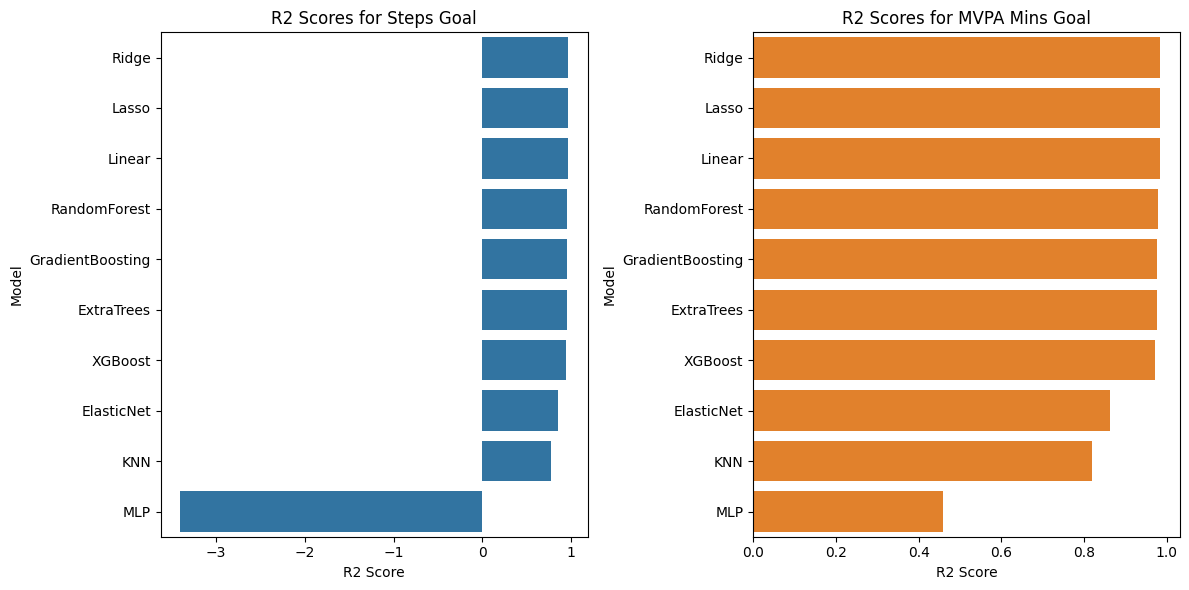

2025-06-07 09:40:33,497 - INFO - R2 comparison plots saved as '../photo/r2_comparison.png'


In [377]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=df_cv_results['steps_goal_R2'], y=df_cv_results.index, color='#1f77b4')
plt.title('R2 Scores for Steps Goal')
plt.xlabel('R2 Score')
plt.ylabel('Model')

plt.subplot(1, 2, 2)
sns.barplot(x=df_cv_results['mvpa_mins_goal_R2'], y=df_cv_results.index, color='#ff7f0e')
plt.title('R2 Scores for MVPA Mins Goal')
plt.xlabel('R2 Score')
plt.ylabel('Model')

plt.tight_layout()
plt.savefig('../photo/r2_comparison.png')
plt.show()
logger.info("R2 comparison plots saved as '../photo/r2_comparison.png'")

In [ ]:
y_train

,steps_goal,mvpa_mins_goal
230,117626.0,1791.0
143,30681.0,726.0
325,9124.0,1518.0
245,10473.0,608.0
379,75770.0,1488.0
...,...,...
33,104042.0,1260.0
35,81493.0,967.0
517,74156.0,2327.0
491,26210.0,1456.0


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=SEED)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)


if hasattr(y_temp, 'columns'):
    print("y_temp is a DataFrame with columns:", y_temp.columns)
    if 'steps_goal' in y_temp.columns:
        y_temp = y_temp['steps_goal'].values
    else:
        raise ValueError("Column 'steps_goal' not found in y_temp. Available columns: {}".format(y_temp.columns))
else:
    print("y_temp is already an array with shape:", y_temp.shape)
    y_temp = y_temp.flatten()  


X_preprocessed = preprocessor.fit_transform(X_temp, y_temp)  


grid_search.fit(X_preprocessed, y_temp)


print("Best params:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)

y_temp is already an array with shape: (446,)


Fitting 2 folds for each of 48 candidates, totalling 96 fits
Best params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Best CV R2: 0.9555577484869885


##  Feature Importance with shap

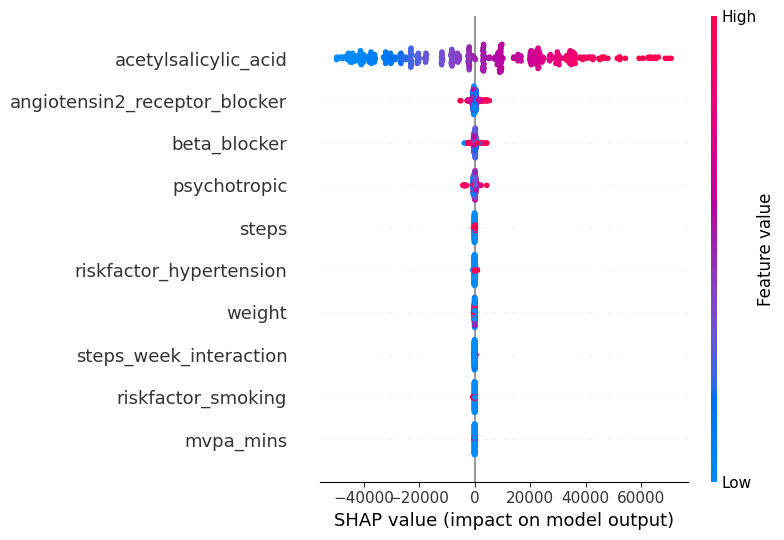

2025-06-06 18:02:30,362 - INFO - SHAP feature importance plot saved as '../photo/shap_feature_importance.png'
2025-06-06 18:02:30,400 - INFO - Feature importance table saved as '../results/feature_importance.csv'


Feature Importance Table:
                          Feature  SHAP Importance
6           acetylsalicylic_acid     24205.966797
9  angiotensin2_receptor_blocker       697.878723
7                   beta_blocker       447.239197
8                   psychotropic       402.495331
1                          steps        71.336090
4        riskfactor_hypertension        56.362099
0                         weight        52.061722
3         steps_week_interaction        49.922958
5             riskfactor_smoking        19.683111
2                      mvpa_mins         2.453477


In [ ]:

explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X_preprocessed)


plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_preprocessed, feature_names=selected_features, show=False)
plt.savefig('../photo/shap_feature_importance.png')
plt.show()
logger.info("SHAP feature importance plot saved as '../photo/shap_feature_importance.png'")


shap_importance = pd.DataFrame({
    'Feature': selected_features,
    'SHAP Importance': np.abs(shap_values).mean(axis=0)
})
shap_importance = shap_importance.sort_values(by='SHAP Importance', ascending=False)
print("Feature Importance Table:\n", shap_importance)

logger.info("Feature importance table saved as '../results/feature_importance.csv'")

In [ ]:

xgb_multi = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=SEED))


param_grid_multi = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [3, 5, 7],
    'estimator__learning_rate': [0.01, 0.1],
    'estimator__subsample': [0.8, 1],
    'estimator__colsample_bytree': [0.8, 1]
}
grid_search_multi = GridSearchCV(
    estimator=xgb_multi,
    param_grid=param_grid_multi,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)


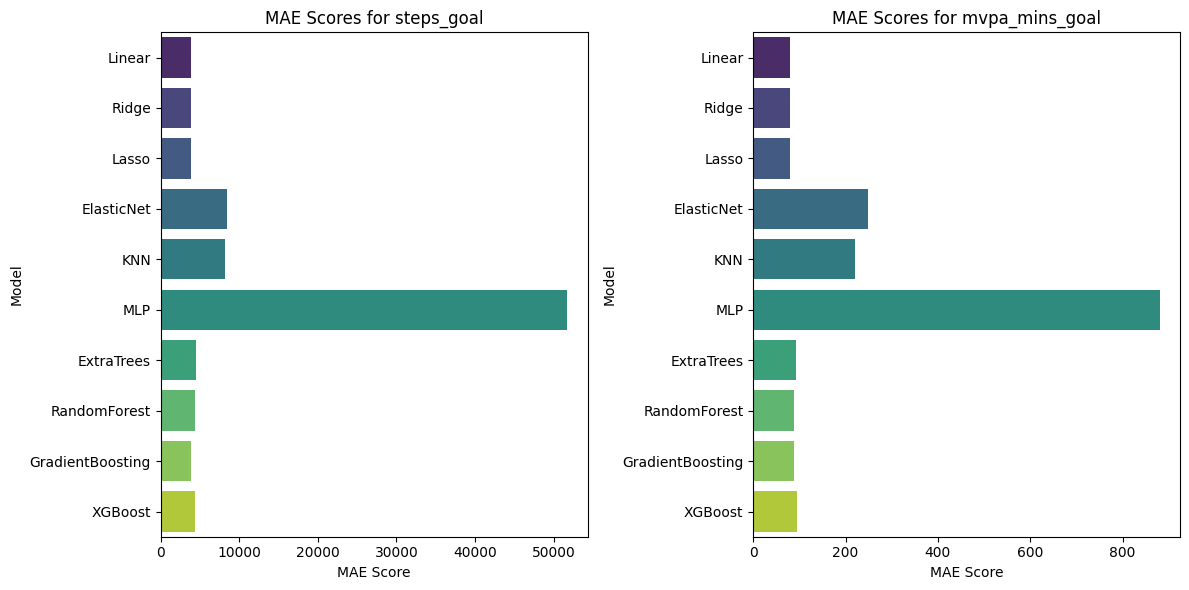

2025-06-06 18:24:18,351 - INFO - MAE comparison plots saved as '../photo/r2_comparison.png'


In [ ]:


plt.figure(figsize=(12, 6))

# Bar plot for MAE of steps_goal
plt.subplot(1, 2, 1)
model_names = list(result_mae_scores.keys())
r2_steps = [result_mae_scores[name]['MAE_steps_goal'] for name in model_names]
sns.barplot(x=r2_steps, y=model_names, palette='viridis')
plt.title('MAE Scores for steps_goal')
plt.xlabel('MAE Score')
plt.ylabel('Model')

# Bar plot for MAE of mvpa_mins_goal
plt.subplot(1, 2, 2)
r2_mvpa = [result_mae_scores[name]['MAE_mvpa_mins_goal'] for name in model_names]
sns.barplot(x=r2_mvpa, y=model_names, palette='viridis')
plt.title('MAE Scores for mvpa_mins_goal')
plt.xlabel('MAE Score')
plt.ylabel('Model')

plt.tight_layout()
plt.savefig('../photo/r2_comparison.png')
plt.show()
logger.info("MAE comparison plots saved as '../photo/r2_comparison.png'")

